# Sitemap Assay

The start of a simple notebook that could hosted for peeopl to test out their sitemaps (and robots.txt) files with.

References:
* [AdvTools](https://advertools.readthedocs.io/en/master/advertools.sitemaps.html)
* [Sitemap viz](https://www.ayima.com/us/insights/analytics-and-cro/how-to-visualize-an-xml-sitemap-using-python.html)



In [1]:
import advertools as adv
import json
import requests
from pyld import jsonld
from bs4 import BeautifulSoup
import urllib.request
import logging
import traceback

In [2]:
%%time 

smurl = 'https://obis.org/sitemap/sitemap_datasets.xml'
# smurl = 'https://infohub.eurocean.net/sitemap/vessels'

iow_sitemap = adv.sitemap_to_df(smurl) # load sitemap to dataframe via advertools

2022-03-30 08:24:47,420 | INFO | sitemaps.py:419 | sitemap_to_df | Getting https://obis.org/sitemap/sitemap_datasets.xml


CPU times: user 34.8 ms, sys: 6.44 ms, total: 41.2 ms
Wall time: 1.06 s


In [3]:
iow_sitemap.info()
iow_sitemap.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4445 entries, 0 to 4444
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   loc              4445 non-null   object             
 1   changefreq       4445 non-null   object             
 2   priority         4445 non-null   float64            
 3   sitemap          4445 non-null   object             
 4   etag             4445 non-null   object             
 5   sitemap_size_mb  4445 non-null   float64            
 6   download_date    4445 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), object(4)
memory usage: 243.2+ KB


,loc,changefreq,priority,sitemap,etag,sitemap_size_mb,download_date
0,https://obis.org/dataset/bcd4cb33-c483-40e6-9d...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a6103-EkOz8u3KFWXpuqNUnh2sgXPSzcQ,0.648685,2022-03-30 13:24:47.433441+00:00
1,https://obis.org/dataset/2dffebfc-8132-445e-a1...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a6103-EkOz8u3KFWXpuqNUnh2sgXPSzcQ,0.648685,2022-03-30 13:24:47.433441+00:00
2,https://obis.org/dataset/7fba9a43-a900-46a5-8a...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a6103-EkOz8u3KFWXpuqNUnh2sgXPSzcQ,0.648685,2022-03-30 13:24:47.433441+00:00
3,https://obis.org/dataset/739c0486-3adf-4e88-9f...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a6103-EkOz8u3KFWXpuqNUnh2sgXPSzcQ,0.648685,2022-03-30 13:24:47.433441+00:00
4,https://obis.org/dataset/73f31d9e-9c11-402b-9e...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a6103-EkOz8u3KFWXpuqNUnh2sgXPSzcQ,0.648685,2022-03-30 13:24:47.433441+00:00


## Unique Sitemaps URLs and resource URLs in IoW

We can quickly grabe the unique URLs from the sitemap column and see how many unique sitemap.xml files we are working with

In [4]:
usm = iow_sitemap.sitemap.unique()
uloc = iow_sitemap["loc"].unique()
print("{} unique sitemap XML file(s) pointing to {} unique resource(s).".format(len(usm), len(uloc)))

1 unique sitemap XML file(s) pointing to 4445 unique resource(s).


## Analyzing the URLs

We can also dive into the URL structure for the resources a bit. 

In [5]:
# Break down all the URL into theor path parts
urldf = adv.url_to_df(list(iow_sitemap['loc']))
urldf.head()

,url,scheme,netloc,path,query,fragment,dir_1,dir_2
0,https://obis.org/dataset/bcd4cb33-c483-40e6-9d...,https,obis.org,/dataset/bcd4cb33-c483-40e6-9d11-a6a779cd8ec7,,,dataset,bcd4cb33-c483-40e6-9d11-a6a779cd8ec7
1,https://obis.org/dataset/2dffebfc-8132-445e-a1...,https,obis.org,/dataset/2dffebfc-8132-445e-a127-3a360208a7b3,,,dataset,2dffebfc-8132-445e-a127-3a360208a7b3
2,https://obis.org/dataset/7fba9a43-a900-46a5-8a...,https,obis.org,/dataset/7fba9a43-a900-46a5-8a4c-861399705482,,,dataset,7fba9a43-a900-46a5-8a4c-861399705482
3,https://obis.org/dataset/739c0486-3adf-4e88-9f...,https,obis.org,/dataset/739c0486-3adf-4e88-9f8d-f0b48ea9b5ad,,,dataset,739c0486-3adf-4e88-9f8d-f0b48ea9b5ad
4,https://obis.org/dataset/73f31d9e-9c11-402b-9e...,https,obis.org,/dataset/73f31d9e-9c11-402b-9e3d-8ed61f2fcc8c,,,dataset,73f31d9e-9c11-402b-9e3d-8ed61f2fcc8c


In [6]:
#set the column sof interest
coi = "query"

In [7]:
# We can not aggregate at various levels...   
e4 = urldf[coi].value_counts()
e4.rename_axis("sources")

e4df = e4.to_frame()
e4df.head(len(e4)) 

,query
,4445


## Plot sitemap diversity

This following section is only of value in cases where is a diversity of path names above the final resource entry in a sitemap.
Otherwise these sections provide no insight.

Note that the _Plot sitemap diversity_ section my not be of value for many groups.  It was used in cases where the URL path has
 more varied structure.  In some cases the structure is the same till the end path element.  In those cases the graphs will be
 busy (slow) and not very useful.

In [8]:
# If we have lots of values above, then we can sum lower end ones into an "others" category.
# This is not needed if the breakdown is small or 1 above the final resource entry in a sitemap.
# With a little trial and error we can see the cutoff for a chart 
breakat = 1
ts = e4df.tail(breakat)[coi].sum()
e4topdf = e4df# [e4df[coi]]  # work in using breakat to get this
e4topdf.reset_index(inplace = True, drop = False)
e4topdf.rename(columns={'index': 'source', coi:'count'},  inplace = True)

t = e4topdf.append({'source':'other', 'count':ts}, ignore_index=True) 
t.head(10)

,source,count
0,,4445
1,other,4445


<AxesSubplot:ylabel='count'>

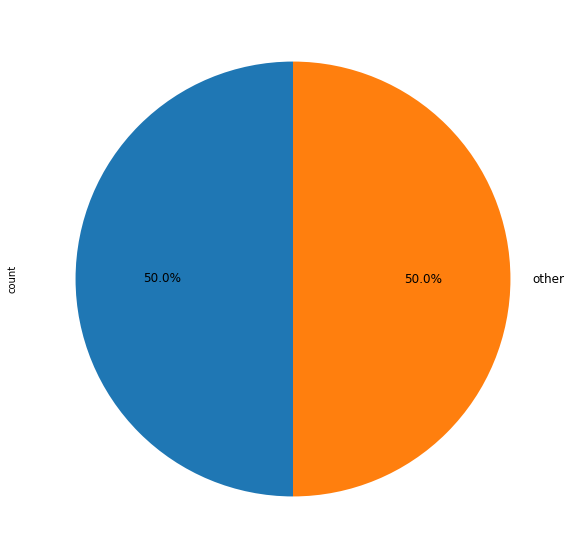

In [9]:
import matplotlib.pyplot as plt
from pandas.plotting import table

plt.figure(figsize=(30,10))

# plot chart
ax1 = plt.subplot(121, aspect='equal')
t.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=t['source'], legend = False, fontsize=12)

# # plot table
# ax2 = plt.subplot(122,  aspect='equal')
# plt.axis('off')
# tbl = table(ax2, t, loc='center')
# tbl.auto_set_font_size(False)
# tbl.set_fontsize(12)
# plt.show()

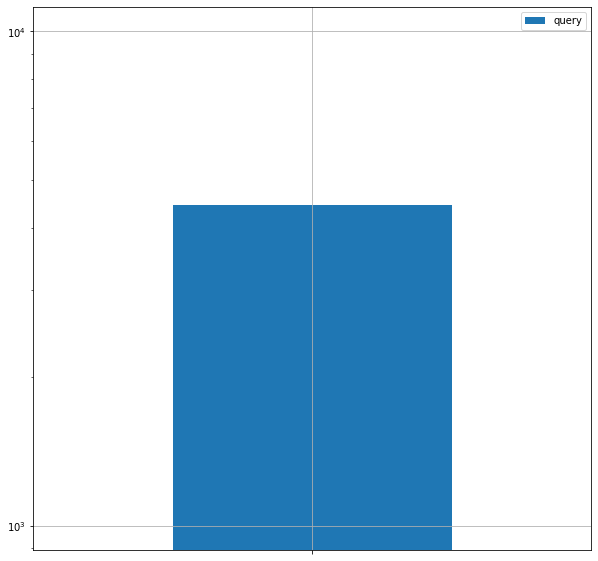

In [10]:
e4sort = e4.sort_values(ascending=True)
plot = e4sort.plot.bar(y='dir_4',legend=True, grid=True, logy = True, figsize=(10, 10))

## Sample and test sitemap entries

In [11]:
# sample the previously generated url data frame
sample_size = 5
sample_df = urldf.groupby("dir_1").sample(n=sample_size, random_state=1, replace=True)


In [12]:
sample_df.head()

,url,scheme,netloc,path,query,fragment,dir_1,dir_2
235,https://obis.org/dataset/c88a7d1c-1609-47d3-bf...,https,obis.org,/dataset/c88a7d1c-1609-47d3-bf1f-a1cb2f7c54f6,,,dataset,c88a7d1c-1609-47d3-bf1f-a1cb2f7c54f6
3980,https://obis.org/dataset/b99fe048-7da1-4558-a1...,https,obis.org,/dataset/b99fe048-7da1-4558-a118-c98c213f4fde,,,dataset,b99fe048-7da1-4558-a118-c98c213f4fde
905,https://obis.org/dataset/708bb02c-e0bb-408f-a8...,https,obis.org,/dataset/708bb02c-e0bb-408f-a867-92f0bc2f70ef,,,dataset,708bb02c-e0bb-408f-a867-92f0bc2f70ef
2763,https://obis.org/dataset/e3394767-0910-462e-b0...,https,obis.org,/dataset/e3394767-0910-462e-b01f-a43eaa524a07,,,dataset,e3394767-0910-462e-b01f-a43eaa524a07
2895,https://obis.org/dataset/dcbb8f12-c869-4d31-aa...,https,obis.org,/dataset/dcbb8f12-c869-4d31-aa8b-23abb27898ce,,,dataset,dcbb8f12-c869-4d31-aa8b-23abb27898ce


### See the URLs resolve

In [13]:
import urllib.request
import requests

ul = sample_df["url"]

for item in ul:
    headers, code, dtype = None, None, None
    
    try:
        x = requests.get(item)
        code = x.status_code
        with urllib.request.urlopen(item) as response:
            info = response.info()
            dtype = info.get_content_type()    # -> text/html

        # headers = x.headers()
    except:
        code = "exception"
        dtype = "exception"
        headers = "exception"
    
    print("URL: {} \ncode {} : {} \nerrors : {}\n --".format(item, code, dtype, headers))

URL: https://obis.org/dataset/c88a7d1c-1609-47d3-bf1f-a1cb2f7c54f6 
code 200 : text/html 
errors : None
 --
URL: https://obis.org/dataset/b99fe048-7da1-4558-a118-c98c213f4fde 
code 200 : text/html 
errors : None
 --
URL: https://obis.org/dataset/708bb02c-e0bb-408f-a867-92f0bc2f70ef 
code 200 : text/html 
errors : None
 --
URL: https://obis.org/dataset/e3394767-0910-462e-b01f-a43eaa524a07 
code 200 : text/html 
errors : None
 --
URL: https://obis.org/dataset/dcbb8f12-c869-4d31-aa8b-23abb27898ce 
code 200 : text/html 
errors : None
 --


### See if they have JSON-LD (static check only, no dynamically loaded JSON-LD yet)

In [14]:
ul = sample_df["url"]

for item in ul:
    html = urllib.request.urlopen(item).read()
    soup = BeautifulSoup(html, "html.parser")
    p = soup.find('script', {'type':'application/ld+json'})
    try:
        # print(len(p.contents))
        print(p.contents[0])
        print("-----------------")
    except Exception as e:
        logging.error(traceback.format_exc())


{
    "@context": {
        "@vocab": "https://schema.org/"
    },
    "@type": "Dataset",
    "@id": "https://obis.org/dataset/c88a7d1c-1609-47d3-bf1f-a1cb2f7c54f6",
    "name": "SPC CoFish Invertebrates Observations Federated States of Micronesia 2006",
    "description": "Marine invertebrate species of commercial interest observed in Federated States of Micronesia during the CoFish surveys in Romanum, Piis-Panewu, Riiken and Yyin (2006) with a mix of survey methods (manta tow, reef benthos transects, and day and night searches)",
    "url": "https://obis.org/dataset/c88a7d1c-1609-47d3-bf1f-a1cb2f7c54f6",
    "sameAs": [
        "https://nzobisipt.niwa.co.nz/resource?r=spc_cofish_invertebrates_fsm_2006"
    ],
    "license": "This work is licensed under a  Creative Commons Attribution Non Commercial (CC-BY-NC) 4.0 License",
    "citation": "Friedman K, Pakoa K, Tardy E, Lasi F (2018): SPC CoFish Invertebrates Observations Federated States of Micronesia 2006. v1.1. The Pacific Commun

### Check JSON-LD structure (static check only, no dynamically loaded JSON-LD yet)

In [15]:
ul = sample_df["url"]

myframe =  {
    "@context":{"@vocab": "https://schema.org/"},
    "@type": "Dataset",
}

context =  { "@vocab": "https://schema.org/" }

for item in ul:
    html = urllib.request.urlopen(item).read()
    soup = BeautifulSoup(html, "html.parser")
    p = soup.find('script', {'type':'application/ld+json'})
    try:
        jld = json.loads(p.contents[0])
        compacted = jsonld.compact(jld, context)
        print(json.dumps(compacted, indent=2))
    except Exception as e:
        logging.error(traceback.format_exc())

{
  "@context": {
    "@vocab": "https://schema.org/"
  },
  "@id": "https://obis.org/dataset/c88a7d1c-1609-47d3-bf1f-a1cb2f7c54f6",
  "@type": "Dataset",
  "citation": "Friedman K, Pakoa K, Tardy E, Lasi F (2018): SPC CoFish Invertebrates Observations Federated States of Micronesia 2006. v1.1. The Pacific Community (SPC). Dataset/Occurrence. https://ipt.sprep.org/resource?r=spc_cofish_invertebrates_fsm_2006&amp;v=1.1",
  "description": "Marine invertebrate species of commercial interest observed in Federated States of Micronesia during the CoFish surveys in Romanum, Piis-Panewu, Riiken and Yyin (2006) with a mix of survey methods (manta tow, reef benthos transects, and day and night searches)",
  "distribution": {
    "@type": "DataDownload",
    "contentUrl": "https://nzobisipt.niwa.co.nz/archive.do?r=spc_cofish_invertebrates_fsm_2006",
    "encodingFormat": "application/zip"
  },
  "includedInDataCatalog": {
    "@id": "https://obis.org",
    "@type": "DataCatalog",
    "url": "http

## COMING SOON

Looad a sample set of triples into RDF lib and run a sample SPARQL query on them.